In [1]:
# Source: 
# https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with
# %20Neural%20Networks.ipynb

In [1]:
import os
from IPython.display import Image

pth = os.getcwd() # where we started jupyter-notebook
pth

'/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy'

# 1 - Sequence to Sequence Learning with Neural Networks

In this series we'll be building a machine learning model to go from once sequence to another, using PyTorch and TorchText. This will be done on German to English translations, but the models can be applied to any problem that involves going from one sequence to another, such as summarization.

In this first notebook, we'll start simple to understand the general concepts by implementing the model from the Sequence to [Sequence Learning with Neural Networks paper](https://arxiv.org/pdf/1409.3215.pdf).


## Introduction

The most common sequence-to-sequence (seq2seq) models are encoder-decoder models, which (commonly) use a recurrent neural network (RNN) to encode the source (input) sentence into a single vector. 
We'll refer to this single vector as a context vector. The context vector is an abstract representation of the entire input sentence. 
This context vector will be decoded by a second RNN which learns to output the target (output) sentence by generating it one word at a time.


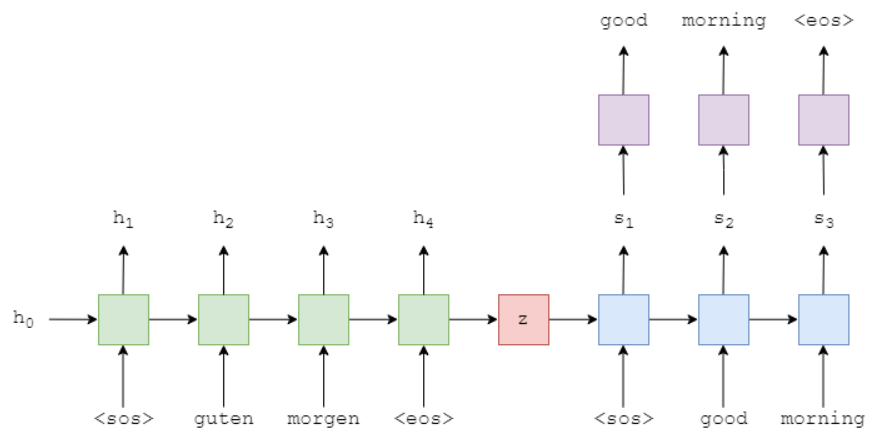

In [2]:
Image(filename= pth + "/images/rnn_translation.png")

The image above shows an example translation.

### RNN Overview: 

The general RNN model takes an input $x_t$ and a hidden state $h_{t-1}$ from the previous time step, and the RNN uses these to output a new hidden state $h_t$. 
Hidden state $h_t$ is a vector representation of the sentence so far (memory). The RNN can be represented as a function of both $x_t$ and $ h_{t-1} $:

**NOTE: RNN could mean any recurrent architecture, such as an LSTM (Long Short-Term Memory) or a GRU (Gated Recurrent Unit)**

#### [RNN's Forward Pass Logic](https://hyp.is/2A7dNArKEeqrZPMWahsTYQ/pytorch.org/docs/stable/nn.html): 
$$ h_t = RNN(x_t, h_{t-1})  $$
$$     = tanh(W_{ih} * x_t + W_{hh} * h_{t-1} + b_{hh}) $$


#### Variable Meanings: 

$ x_t = $ input tensor at time $t$

$ h_t = $ hidden state tensor at time $t$

$ h_{t-1} = $ hidden state of the previous layr at time $t - 1$ or the initial hidden state at time $0$. 

[The weight tensors are:](https://hyp.is/e_hoDA0AEeqmEr_FYxTetw/pytorch.org/docs/stable/nn.html)

$W_{ih} =$ the learnable input-to-hidden weight tensor **for the layers**, where each row corresponds to the input-hidden weights for a particular layer. 

If layer = 0, $W_{ih}$ has shape 
(4 * `hiddenLayerSize`, `inputLayerSize`) 

else it has shape 
(4 * `hiddenLayerSize`, `numDirections` * `hiddenLayerSize`)} 

$W_{hh} =$ the learnable hidden-to-hidden weight tensor **for the layers**, where each row corresponds to the hidden-hidden weights for a particular layer. 
This tensor has shape (`hiddenLayerSize`, `hiddenLayerSize`) 


[The bias tensors are:](https://hyp.is/wL3u8g0BEeqCvecy5984hQ/pytorch.org/docs/stable/nn.html)

$b_{ih} = $the learnable input-to-hidden bias of the layers. Is a 1-dim tensor with shape (`hiddenLayerSize`) \\
$b_{hh} = $the learnable hidden-to-hidden bias of the layers. Is a 1-dim tensor with shape (`hiddenLayerSize`) \\





### Encoder Overview: 

The input sentence "guten morgen" is input into the encoder (green boxes) one word at a time. 
We also append a *start of sequence* `<sos>` to the start of the sentence and *end of sequence* `<eos>` token to the end of the sentence. 

At each time-step, the input to the encoder RNN is both the current word 

##### Variable Interpretations for Encoder: 


[The inputs are:](https://hyp.is/Wj40JArNEeqG-0uE-Y9kqg/pytorch.org/docs/stable/nn.html)

\begin{array}{ll}
X = \{x_1, x_2, ..., x_T\} \\
x_1 = \text{<sos>} \\
x_2 = \text{guten} \\
x_3 = \text{morgen} \\
x_4 = \text{<eos>} \\
\end{array}

The hidden states are: 

\begin{array}{ll}
\href{https://hyp.is/h9bs-Az_EeqOS5vSrKnHmA/pytorch.org/docs/stable/nn.html}{h_0} = \text{initial hidden state, usually initialized to zeros or a learned parameter.} \\
h_1 = RNN(x_1, h_0) = \text{the hidden state after applying RNN on first input } x_1 \text{and previous hidden state}, h_0 \\
h_2 = RNN(x_2, h_1) = \text{the hidden state after applying RNN on second input } x_2 \text{and previous hidden state}, h_1 \\
h_3 = RNN(x_3, h_2) = \text{the hidden state after applying RNN on third input } x_3 \text{and previous hidden state}, h_2 \\
h_4 = RNN(x_4, h_3) = \text{the hidden state after applying RNN on fourth input } x_4 \text{and previous hidden state}, h_3 \\
\end{array}


Once the final word, $x_T$, has been passed into the RNN, we use the final hidden state, $h_T$, as the context vector (we will call this resulting context vector $z$, so we let $z := h_T$). This context vector now represents the entire source sentence.


### Decoder Overview: 

Now we have our context vector, $z$, we can start decoding it to get the target sentence, "good morning". Again, we append start and end of sequence tokens to the target sentence. At each time-step, the input to the `DecoderRNN` (blue) is the current word, $y_t$, as well as the hidden state from the previous time-step, $s_{t-1}$, where the initial decoder hidden state, $s_0$, is the context vector, $s_0 = z = h_T$. This says the **initial decoder hidden state is the final encoder hidden state.** Thus, similar to the encoder, we can represent the decoder as:

$$s_t = \text{DecoderRNN}(y_t, s_{t-1})$$

#### Variable Meanings: 

\begin{array}{ll}
s_t = \text{hidden state of decoder} \\
s_{t-1} = \text{hidden state of decoder from previous time step} \\
s_0 = h_t =: z = \text{initial decoder hidden state, or final encoder hidden state} \\
y_t = \text{current word input to the decoder} \\
\end{array}

Inside the decoder, we need to go from the hidden state $s_t$ to an actual word, therefore at each time-step we use the hidden state $s_t$ to predict (by passing it through a `Linear` layer $f()$, shown in purple) the next word in the sequence, $\hat{y}_t$. 

$$\hat{y}_t = f(s_t)$$

The words in the decoder are always generated one after another, with one per time-step. We always use `<sos>` for the first input to the decoder, $y_1$, but for subsequent inputs, $y_{t-1}$, we will sometimes use the actual, ground truth next word in the sequence, $y_t$ and sometimes use the word predicted by our decoder, $\hat{y}_{t-1}$. This is called [*teacher forcing*](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/). 


### Training Overview: 

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference (real world usage) it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our `loss`. We then use this `loss` to update all of the parameters in our model.



## Preparing Data

We'll be coding up the models in PyTorch and using TorchText to help us do all of the pre-processing required. We'll also be using spaCy to assist in the tokenization of the data.

In [ ]:
## Preparing the Data
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)

# note about reproducibility in CUDA: 
# https://hyp.is/dOiOAAuzEeqcu2OxIZfR4w/pytorch.org/docs/stable/notes/randomness.html
torch.backends.cudnn.deterministic = True 

### 1. Create the Tokenizers

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. We'll start talking about the sentences being a sequence of tokens from now, instead of saying they're a sequence of words. What's the difference? Well, "good" and "morning" are both words and tokens, but "!" is a token, not a word.

spaCy has model for each language ("de" for German and "en" for English) which need to be loaded so we can access the tokenizer of each model.

In [5]:
# Download the spacy models via command line:
# conda activate pynlp_env
# cd /development/.../NLPStudy/data
# python -m spacy download en
# python -m spacy download de

# Then load the models
spacyDE = spacy.load('de')
spacyEN = spacy.load('en')

### 2. Create the Tokenizer Functions

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In the [paper](https://arxiv.org/pdf/1409.3215.pdf) we are implementing, they find it beneficial to reverse the order of the input which they believe "introduces many short term dependencies in the data that make the optimization problem much easier".

In [6]:
# Creating the tokenizer functions
# NOTE: reversing due to optimization ease

def tokenizeGerman(germanText: str):
    """
    Tokenizes German text from a string into a list of strings (as tokens)
    and reverses it
    :param germanText: 
    :return: 
    """
    return [tok.text for tok in spacyDE.tokenizer(germanText)][::-1]

def tokenizeEnglish(englishText: str):
    """
    Tokenizes English text from a string into a list of strings (as tokens)
    and reverses it
    
    :param englishText: 
    :return: 
    """
    return [tok.text for tok in spacyEN.tokenizer(englishText)]

We set the tokenize argument to the correct tokenization function for each, with German being the `SRC` (source) field and English being the `TRG` (target) field. The `Field` also appends the "start of sequence" and "end of sequence" tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

[To read more about Field's arguments](https://github.com/pytorch/text/blob/master/torchtext/data/field.py#L61)


In [7]:
# German = source language, English = target language

# tokenize:  The function used to tokenize strings using this field into
#             sequential examples.
# init_token: A token that will be prepended to every example using this
#             field, or None for no initial token. Default: None.
# eos_token: A token that will be appended to every example using this
#             field, or None for no end-of-sentence token. Default: None.
# lower: Whether to lowercase the text in this field. Default: False.
SRC = Field(tokenize = tokenizeGerman,  
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

TRG = Field(tokenize = tokenizeEnglish,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

Next, we download and load the train, validation and test data.

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset). 
This is a dataset with ~30,000 parallel English, German and French 
sentences, each with ~12 words per sentence.

In [8]:
# `exts` : specifies which languages to use as the source and target
# (source goes first) 
# `fields`: specifies which field to use for the source and target.

# NOTE: after this, the data is stored in 
# a folder under NLPSTUDY called '.data'
trainData, validationData, testData = \
    Multi30k.splits(exts = ('.de', '.en'),
                    fields = (SRC, TRG))

In [9]:
# Double-checking we have the right number of examples: 
print(f"Number of training examples: {len(trainData.examples)}")
print(f"Number of validation examples: {len(validationData.examples)}")
print(f"Number of testing examples: {len(testData.examples)}")

print("\n")

# Printing out an example to make sure the source sentence is
# reversed (if you know German); the target (english) is in proper order, though. 
print(trainData.examples[0])
print(vars(trainData.examples[0]))

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


### 4. Building the vocabulary

Next, we build the *vocabulary* for the source and target languages. 

The vocabulary is used to associate each unique token (word) with an index (an integer), similar to the way a dictionary works (?).

This is used to build a one-hot encoding for each token (a vector of all zeros except for the position represented by the index, which is 1). 

The vocabularies of the source and target languages are distinct.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

WARNING: It is important to note that your vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into your model, giving you artifically inflated validation/test scores.

In [10]:
SRC.build_vocab(trainData, min_freq=2)
TRG.build_vocab(trainData, min_freq=2)

In [11]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### 5. (Final) Create the Iterators

The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a `src` attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a `trg` attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary. 

We also need to define a `torch.device`. This is used to tell TorchText to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return `True` if a GPU is detected on our computer. We pass this `device` to the iterator.

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us! 

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
# Creating the training iterator

BATCH_SIZE = 128

trainIterator, validationIterator, testIterator = BucketIterator.splits(
    (trainData, validationData, testData),
    batch_size = BATCH_SIZE,
    device = device)

In [14]:
trainIterator

## Building the Seq2Seq Model

We'll be building our model in three parts. The encoder, the decoder and a seq2seq model that encapsulates the encoder and decoder and will provide a way to interface with each.


### Encoder

We will use a 2-layer [LSTM (long short term memory)](https://hyp.is/R5jTMACPEeqEBPshU7EI4A/pytorch.org/docs/stable/nn.html) for the encoder (the paper uses 4-layer LSTM)


##### Two-Layer RNN: 

For a multi-layer RNN, the input sentence, $X$, goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. 

Let's represent each layer with a superscript: 

The hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(x_t, h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Using a multi-layer RNN also means we'll also need an initial hidden state as input per layer, $h_0^l$, and we will also output a context vector per layer, $z^l$.

##### Contrasting LSTM and RNN: 

LSTMs are a type of RNN which instead of just taking in a hidden state $h_{t-1}$ and returning a new hidden state $h_t$ per time-step, also take in and return a *cell state* (a hidden internal state), $c_t$, per time-step.

\begin{array}{ll}
       h_t = \text{RNN}(x_t, h_{t-1}) \\
(h_t, c_t) = \text{LSTM}(x_t, (h_{t-1}, c_{t-1})) \\
     h_0^l = \text{tensor of zeros} \\
     c_0^l = \text{tensor of zeros} \\
       z^l = (h_T^l, c_T^l) = \text{final hidden state and final cell state tuple, considered now as the context vector for the LSTM.} \\
\end{array}

* [About tensor shapes of $h_0$ and $c_0$](https://hyp.is/Zhr-Kg0wEeqln6cdLJLR0A/pytorch.org/docs/stable/nn.html)

##### Two-Layer LSTM

Extending our multi-layer equations to LSTMs, we get:

\begin{array}{ll}
(h_t^1, c_t^1) = \text{EncoderLSTM}^1(x_t, (h_{t-1}^1, c_{t-1}^1)) \\
(h_t^2, c_t^2) = \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2)) \\
\end{array}

Note how only our hidden state from the first layer $h_t^1$ is passed as input to the second layer, and not the cell state $c_t^1$.

So our EncoderLSTM looks something like this: 


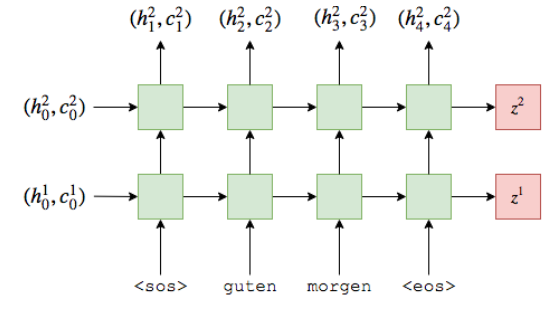

In [21]:
Image(filename = pth + '/images/encoder.png')


We create this in code by making an `Encoder` module, which requires we inherit from `torch.nn.Module` and use the `super().__init__()` as some boilerplate code. 

#####[ Inputs of `Encoder`:](https://hyp.is/GDsY3A1BEeqDK2cg-mU_SQ/pytorch.org/docs/stable/nn.html)
The EncoderRNN takes the following arguments:
- `inputDim` = the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.
- `embedDim` = the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with `embedDim` dimensions.
- `hiddenDim` = the dimensionality of the hidden and cell states (which are tensors).
- `numLayers` = the number of layers in the RNN.
- `dropout` is the amount of dropout to use. This is a regularization parameter to prevent overfitting. Check out [this](https://www.coursera.org/lecture/deep-neural-network/understanding-dropout-YaGbR) for more details about dropout.

##### Embedding Layer of `Encoder` (brief description): 
This is a step where the words - technically, the indexes of the words - are passed into the RNN, where the words are transformed into vectors. 
- The embedding layer is created using [`nn.Embedding`](https://hyp.is/cv2pSAeqEeqIRHv7JAjgtA/pytorch.org/docs/stable/nn.html)
- The LSTM is created using [`nn.LSTM`](https://hyp.is/R5jTMACPEeqEBPshU7EI4A/pytorch.org/docs/stable/nn.html) 
- The dropout layer is created with [`nn.Dropout`](https://hyp.is/qrKgZg0-EeqHWhNj0dgBjw/pytorch.org/docs/stable/nn.html). 
	- One thing to note is that the `dropout` argument to the LSTM is how much dropout to apply between the layers of a multi-layer RNN, i.e. between the hidden states output from layer $l$ and those same hidden states being used for the input of layer $l+1$.

##### Forward Pass of `Encoder`: 
\begin{array}{ll}
h_t = RNN(x_t, h_{t-1}) \\
    = tanh(W_{ih} * x_t + W_{hh} * h_{t-1} + b_{hh}) \\
\end{array}

In the `forward` method, we pass in the source sentence, $X$, which is converted into dense vectors using the `embedding` layer, and then dropout is applied. These embeddings are then passed into the RNN. As we pass a whole sequence to the RNN, it will automatically do the recurrent calculation of the hidden states over the whole sequence. 
- NOTE: no need to pass an initial hidden $h_0$ or initial cell state $c_0$ to the RNN since if no hidden/cell state is passed to the RNN, it will [automatically create an initial hidden/cell state as a tensor of all zeros](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM).

##### [Outputs of `Encoder`:](https://hyp.is/3_DFrAx5EeqqUF__1DKA2g/pytorch.org/docs/stable/nn.html)
The RNN returns: 
- `outputs` (the top-layer hidden state for each time-step)
- `hidden` (the final hidden state for each layer, $h_T$, stacked on top of each other) 
- `cell` (the final cell state for each layer, $c_T$, stacked on top of each other).

As we only need the final hidden and cell states (to make our context vector), `forward` only returns `hidden` and `cell`.

The sizes of each of the tensors is left as comments in the code. In this implementation `numDirections` will always be 1, however note that bidirectional RNNs (covered in tutorial 3) will have `numDirections` = 2.

In [19]:
class Encoder(nn.Module):
    
    def __init__(self, inputDim, embedDim, hiddenDim, numLayers, dropout):
        super().__init__()
        
        self.hiddenDim = hiddenDim
        self.numLayers = numLayers
        
        self.embedding = nn.Embedding(num_embeddings=inputDim, 
                                      embedding_dim=embedDim)
        
        self.rnn = nn.LSTM(input_size=embedDim, 
                           hidden_size=hiddenDim,
                           num_layers=numLayers,
                           dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, src):
        """
        
        :param src: tensor of size (source sentence length, batchsize) (???)
        :return: 
        """
        
        srcEmbedding = self.dropout(self.embedding(src))
        # size is (src sentence len, batch size, embed dim)
        
        outputs, (hidden, cell) = self.rnn(srcEmbedding)

        # EXPLANATION OF LSTM outputs: 
        # https://hyp.is/3_DFrAx5EeqqUF__1DKA2g/pytorch.org/docs/stable/nn.html
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #outputs are always from the top hidden layer
        
        return hidden, cell 

### Decoder

Next, we'll build our decoder, which will also be a 2-layer (4 in the paper) LSTM.


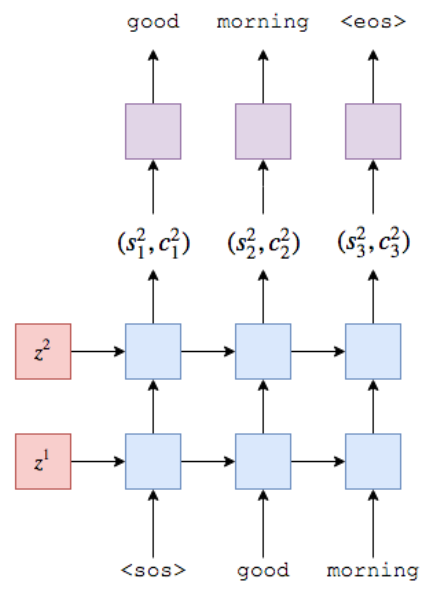

In [20]:
Image(filename=pth + "/images/decoder.png")

The `Decoder` class does a single step of decoding, that is a single token per time-step. 
1. The first layer will receive a hidden and cell state from the previous time-step, $(s_{t-1}^1, c_{t-1}^1)$, and feed it through the LSTM with the current token, $y_t$
2. The `Decoder` uses this to produce a new hidden and cell state, $(s_t^1, c_t^1)$. 
3. The subsequent layers will use the hidden state from the layer below, $s_t^{l-1}$, and the previous hidden and cell states from their layer, $(s_{t-1}^l, c_{t-1}^l)$. 
This provides equations very similar to those in the `Encoder`:
\begin{array}{ll}
(s_t^1, c_t^1) = \text{DecoderLSTM}^1(y_t, (s_{t-1}^1, c_{t-1}^1)) \\
(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2)) \\
(s_0^l,c_0^l) = \text{the initial hidden and cell states to the} Decoder \text{ from layer } l. \\
z^l = \text{the context vectors from layer } l. \\
(h_T^l,c_T^l) = \text{the final hidden and cell states of the } Encoder \text{ from the same layer } l.\\
\end{array}
4. After, pass the hidden state from the top layer of the RNN, $s_t^L$, through a linear layer, $f$, to make a prediction $\hat{y}_{t+1}$ of what the next token in the target (output) sequence should be.
$$\hat{y}_{t+1} = f(s_t^L)$$

##### Inputs of `Decoder`: 
The arguments and initialization are similar to the `Encoder` class, except we now have an `outputDim` which is the size of the one-hot vectors that will be input to the `Decoder`. These are equal to the vocabulary size of the output/target. There is also the addition of the `Linear` layer, used to make the predictions from the top layer hidden state.

##### Forward Pass of `Decoder`:
Within the `forward` method, we: 
1. Accept a batch of input tokens, previous hidden states and previous cell states. As we are only **decoding one token at a time**, the input tokens will always have a sequence length of 1. 
2. We [`torch.unsqueeze`](https://hyp.is/DLB4Gg1EEeqN4msK9VxS4g/pytorch.org/docs/stable/torch.html) the input tokens to add a sentence length dimension of 1. 
3. Then, similar to the `Encoder`, we pass through an embedding layer and apply dropout. 
4. This batch of embedded tokens is then passed into the RNN with the previous hidden and cell states. 
5. This produces an `output` (hidden state from the top layer of the RNN), a new `hidden` state (one for each layer, stacked on top of each other) and a new `cell` state (also one per layer, stacked on top of each other). 
6. We then pass the `output` (after getting rid of the sentence length dimension) through the linear layer to receive our `prediction`. 
7. We then return the `prediction`, the new `hidden` state and the new `cell` state.

**Decision to use [`nn.LSTM`](https://hyp.is/R5jTMACPEeqEBPshU7EI4A/pytorch.org/docs/stable/nn.html) over [`nn.LSTMCell`](https://hyp.is/iCPdjg1EEeq9vlulaBtGuQ/pytorch.org/docs/stable/nn.html)**: 
As we always have a sequence length of 1, we could use `nn.LSTMCell`, instead of `nn.LSTM`, as it is designed to handle a batch of inputs that aren't necessarily in a sequence. `nn.LSTMCell` is just a single cell and `nn.LSTM` is a wrapper around potentially multiple cells. 
Using the `nn.LSTMCell` in this case would mean we don't have to `unsqueeze` to add a fake sequence length dimension, but we would need one `nn.LSTMCell` per layer in the decoder and to ensure each `nn.LSTMCell` receives the correct initial hidden state from the encoder. 
All of this makes the code less concise - hence the decision to stick with the regular `nn.LSTM`.

In [23]:
import torch.tensor as Tensor 

class Decoder(nn.Module):
    
    def __init__(self, outputDim:int, embedDim: int, hiddenDim: int, 
                 numLayers: int, dropout: float):
        
        super().__init__()
        
        self.outputDim = outputDim
        self.hiddenDim = hiddenDim
        self.numLayers = numLayers
        
        self.embeddingLayer = nn.Embedding(num_embeddings=outputDim,
                                           embedding_dim=embedDim)
        
        self.rnn = nn.LSTM(input_size=embedDim, hidden_size=hiddenDim,
                           num_layers=numLayers, dropout=dropout)
        
        self.outputLayer = nn.Linear(in_features=hiddenDim, 
                                     out_features=outputDim)
        
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, inputTokens: Tensor, hidden: Tensor, cell: Tensor):
        """
        
        :param inputTokens: tensor with shape (batchSize)
        
        NOTE: numDirections = 1 here (since it is one-directional LSMT)
        :param hidden: tensor with shape (numLayers * numDirections, batchSize, hiddenDim)
        hidden state shape is: (numLayers, batchSize, hiddenDim)
        :param cell: tensor with shape (numLayers * numDirections, batchSize, hiddenDim)
        cell shape is: (numlayers, batchSize, hiddenDim)
        :return: 
        """
        
        inputTokens = inputTokens.unsqueeze(0)
        ## gives input shape (1, batchSize)
        
        embeddedTokens = self.dropout(self.embeddingLayer(inputTokens))
        ## gives embedded shape (1, batchSize, embedDim)
        
        # input to lstm: (input, (h_0, c_0))
        output, (hidden, cell) = self.rnn(embeddedTokens, (hidden, cell))
        ## output shape: (sentenceLen, batchSize, hiddenDim * numDirections)
        ## hidden shape: (numLayers * numDirections, batchSize, hiddenDim)
        ## cell shape: (numLayers * numDirections, batchSize, hiddenDim)
        # ------------------------------------------------------------------
        ### NOTE: since sentence length = 1, numDIrections = 1, then: 
        ## output shape: (1, batchSize, hiddenDim )
        ## hidden shape: (numLayers, batchSize, hiddenDim)
        ## cell shape: (numLayers, batchSize, hiddenDim)
        
        # passing output of LSTM through the linear layer
        prediction = self.outputLayer(output.squeeze(0))
        ## prediction size: (batchSize, outputDim)
        
        return prediction, hidden, cell 
        
        

## Seq2Seq


For the final part of the implemenetation, we'll implement the seq2seq model. This will handle:
- receiving the input/source sentence
- using the encoder to produce the context vectors
- using the decoder to produce the predicted output/target sentence

Our full model will look like this:

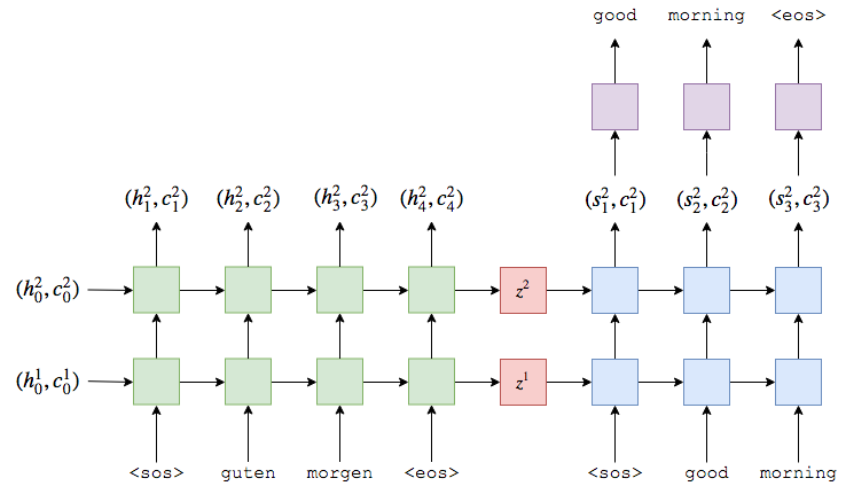

In [24]:
Image(filename = pth + "/images/seq2seq.png")


The `Seq2Seq` model takes in an `Encoder`, `Decoder`, and a `device` (used to place tensors on the GPU, if it exists).

For this implementation, we have to ensure that the number of layers and the hidden (and cell) dimensions are equal in the `Encoder` and `Decoder`. This is not always the case, you do not necessarily need the same number of layers or the same hidden dimension sizes in a sequence-to-sequence model. However, if you do something like having a different number of layers you will need to make decisions about how this is handled. For example, if your encoder has 2 layers and your decoder only has 1, how is this handled? Do you average the two context vectors output by the decoder? Do you pass both through a linear layer? Do you only use the context vector from the highest layer? Etc.

Our `forward` method takes the source sentence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. When decoding, at each time-step we will predict what the next token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(s_t^L)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability `1 - teacher_forcing_ratio`, we will use the token that the model predicted as the next input to the model, even if it doesn't match the actual next token in the sequence.

The first thing we do in the `forward` method is to create an `outputs` tensor that will store all of our predictions, $\hat{Y}$.

We then feed the input/source sentence, $X$/`src`, into the encoder and receive out final hidden and cell states.

The first input to the decoder is the start of sequence (`<sos>`) token. As our `trg` tensor already has the `<sos>` token appended (all the way back when we defined the `init_token` in our `TRG` field) we get our $y_1$ by slicing into it. We know how long our target sentences should be (`max_len`), so we loop that many times. The last token input into the decoder is the one **before** the `<eos>` token - the `<eos>` token is never input into the decoder.

During each iteration of the loop, we:
- pass the input, previous hidden and previous cell states ($y_t, s_{t-1}, c_{t-1}$) into the decoder
- receive a prediction, next hidden state and next cell state ($\hat{y}_{t+1}, s_{t}, c_{t}$) from the decoder
- place our prediction, $\hat{y}_{t+1}$/`output` in our tensor of predictions, $\hat{Y}$/`outputs`
- decide if we are going to "teacher force" or not
- if we do, the next `input` is the ground-truth next token in the sequence, $y_{t+1}$/`trg[t]`
- if we don't, the next `input` is the predicted next token in the sequence, $\hat{y}_{t+1}$/`top1`, which we get by doing an `argmax` over the output tensor

Once we've made all of our predictions, we return our tensor full of predictions, $\hat{Y}$/`outputs`.

**Note**: our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\ \
    \text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Later on when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\ \
    \text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

In [35]:
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder: Encoder, decoder: Decoder, device):
        
        super().__init__()
        
        self.encoder: Encoder = encoder 
        self.decoder: Decoder = decoder
        self.device = device
        
        assert encoder.hiddenDim == decoder.hiddenDim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        
        assert encoder.numLayers == decoder.numLayers, \
            "Encoder and decoder must have equal number of layers!"
        
        
    
    def forward(self, src: Tensor, trg: Tensor, teacherForcingRatio = 0.5):
        """
        
        :param src:  tensor made from source sentence. 
        Shape is (srcSentenceLen, batchSize)
        :param trg:  tensor made from target sentence. 
        Shape is (trgSentenceLen, batchSize)
        :param teacherForcingRatio: is probability of using teacher forcing 
        (of using ground-truth inputs)
        :return: 
        """
        maxLen, batchSize = trg.shape
        trgVocabSize: int = self.decoder.outputDim 
        
        # create tensor to store decoder outputs
        outputs: Tensor = torch.zeros(maxLen, batchSize, trgVocabSize).to(self.device)
        
        # last hidden state of encoder IS initial hidden state of decoder: 
        hidden, cell = self.encoder(src)
        
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        
        for t in range(1, maxLen):
            
            # insert input token embedding, previous hidden state, 
            # and previous cell state into decoder
            # Get output tensor (preidctions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # place predictions in a tensor holding predictions
            # for each token
            outputs[t] = output 
            
            # decide if we are going to use teacher forcing or not
            isUseTeacherForce = random.random() < teacherForcingRatio
            
            # get the highest predicted token from our predictions
            maxPredToken = output.argmax(1) # TODO: why index 1?
            
            # if use teacher forcing, the next token is next input, else
            # else use predicted token
            input = trg[t] if isUseTeacherForce else maxPredToken
        
        return outputs 
            

## Training the Seq2Seq Model

Now we have our model implemented, we can begin training it.

### Step 1: Initialize the Seq2Seq Model

First, we'll initialize our model. 

The input and output dimensions are defined by the size of the vocabulary. The embedding dimenions and dropout for the `Encoder` and `Decoder` can be different, but the number of layers and the size of the hidden/cell states must be the same.

We then define the `Encoder`, `Decoder` and then our `Seq2Seq` model, which we place on the device.

In [36]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENCODER_EMB_DIM = 256
DECODER_EMB_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 2
ENCODER_DROPOUT = 0.5
DECODER_DROPOUT = 0.5

lstmEncoderModel = Encoder(inputDim = INPUT_DIM, embedDim = ENCODER_EMB_DIM,
                           hiddenDim=HIDDEN_DIM, numLayers=NUM_LAYERS,
                           dropout=ENCODER_DROPOUT)

lstmDecoderModel = Decoder(outputDim=OUTPUT_DIM, embedDim=DECODER_EMB_DIM,
                           hiddenDim=HIDDEN_DIM, numLayers=NUM_LAYERS,
                           dropout=DECODER_DROPOUT)

seq2seqModel = Seq2Seq(encoder = lstmEncoderModel, 
                       decoder= lstmDecoderModel,
                       device=device).to(device)

### Step 2: Initialize the Weights of the Seq2Seq Model

Next up is initializing the weights of our model. In the paper they state they initialize all weights from a uniform distribution between -0.08 and +0.08, i.e. $\mathcal{U}(-0.08, 0.08)$.

We initialize weights in PyTorch by creating a function which we `apply` to our model. When using `apply`, the `init_weights` function will be called on every module and sub-module within our model. For each module we loop through all of the parameters and sample them from a uniform distribution with `nn.init.uniform_`.

In [38]:
def initWeights(model):
    """
    Initialize the weights of the model from a uniform distribution U(-0.08, 0.08)
    
    :param model: any model (seq2seq, lstm ...)
    :return: Update the `model` by looping through all parameters and
    sampling them from a uniform distribution. 
    """
    for name, param in model.named_parameters():
        nn.init.uniform_(tensor = param.data, a = -0.08, b = 0.08)
        
        

# the apply() method applies the function `fn` to every submodule recursively.
seq2seqModel.apply(fn = initWeights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (embeddingLayer): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (outputLayer): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [44]:
# Define function to calculate number of trainable parameters in the model
def countParameters(model):
    # note: a parameter is trainable if it has `requires_grad` property
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [47]:
print(f'The model has {countParameters(seq2seqModel):,} trainable parameters')

The model has 13,898,501 trainable parameters


### Step 3: Define the Optimizer (Adam)

In [48]:
# Define the optimizer to update parameters in the training loop
adamOptimizer = optim.Adam(seq2seqModel.parameters())
adamOptimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

### Step 4: Define the Loss (Cross Entropy)

In [50]:
# Define the loss. CrossEntropyLoss calculates log softmax AND neg log 
# likelihood of our predictions

# THe loss calculates average loss per token, but by passing the index of
# the <pad> token as the ignore_index argument we ignore the loss
# whenever the target token is a padding token. 
PAD_INDEX = TRG.vocab.stoi['<pad>']

crossEntropyLoss = nn.CrossEntropyLoss(ignore_index= PAD_INDEX)
crossEntropyLoss

CrossEntropyLoss()

### Step 5: Define the Training Loop

Next, we'll define our training loop. 

First, we'll set the model into "training mode" with `model.train()`. This will turn on dropout (and batch normalization, which we aren't using) and then iterate through our data iterator.

- **NOTE:**: the `Decoder` loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Here, when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

At each iteration:
- get the source and target sentences from the batch, $X$ and $Y$
- zero the gradients calculated from the last batch
- feed the source and target into the model to get the output, $\hat{Y}$
- as the **loss function only works on 2d inputs with 1d targets we need to flatten each of them with `.view`**
    - we slice off the first column of the output and target tensors as mentioned above
- calculate the gradients with `loss.backward()`
- clip the gradients to prevent them from exploding (a common issue in RNNs)
- update the parameters of our model by doing an optimizer step
- sum the loss value to a running total

Finally, we return the loss that is averaged over all batches.

In [51]:
def train(seqModel: Seq2Seq, iterator, optimizer, lossFunction, clip: int):
    
    seqModel.train()
    
    lossPerEpoch: int = 0
    
    for epoch, batch in enumerate(iterator):
        
        # 1. Getting source and target sentences from batch
        srcSentence = batch.src
        trgSentence = batch.trg 
        
        # 2. Zero the gradients from the last batch
        optimizer.zero_grad()
        
        # 3. Feed the source and target sentences into the seq2seq model
        # to get the output tensor of predictions.
        output = seqModel(srcSentence, trgSentence)
        ### trgSentence = tensor of shape (trgSentenceLen, batchSize)
        ### output = tensor of shape (trgSentenceLen, batchSize, outputDim)
        
        # 4. Need to flatten the outputs to be in 2d input with 1d target
        # so that loss can take this as an argument. 
        # (by slicing off the first column of the output and target tensors
        # as mentioned above)
        output = output[1:].view(-1, output.shape[-1])
        trgSentence = trgSentence[1:].view(-1)
        ## trgSentence shape now: ((trgSentenceLen - 1) * batchSize)
        ## output shape now: ((trgSentenceLen - 1) * batchSize, outputDim)
        
        # 5. Calculate gradients
        loss = lossFunction(output, trgSentence)
        loss.backward()
        
        # 6. Clip gradient so it doesn't explode
        torch.nn.utils.clip_grad_norm_(parameters = seqModel.parameters(),
                                       max_norm = clip)
        
        # 7. Update parameters of model
        optimizer.step()
        
        # 8. Sum the loss value to a running total
        lossPerEpoch += loss.item()
        
    return lossPerEpoch / len(iterator) # average loss

### Step 6: Define the Evaluation Loop

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

*We must remember to set the model to evaluation mode with `model.eval()`. This will turn off dropout (and batch normalization, if used).*

We use the `with torch.no_grad()` block to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up. 

The iteration loop is similar (without the parameter updates), however we must ensure we turn teacher forcing off for evaluation. This will cause the model to only use it's own predictions to make further predictions within a sentence, which mirrors how it would be used in deployment.

In [52]:
def evaluate(seqModel: Seq2Seq, iterator, lossFunction):
    
    model.eval()
    
    lossPerEpoch = 0
    
    with torch.no_grad():
        
        for epoch, batch in enumerate(iterator):
            srcSentence = batch.src
            trgSentence = batch.trg
            
            # Turn off teacher forcing
            output = seqModel(srcSentence, trgSentence, 0)
            ## trgSentence = tensor with shape (trgSentenceLen, batchSize)
            ## output = tensor with shape (trgSentenceLen, batchSize, outputDim)
            
            output = output[1:].view(-1, output.shape[-1])
            trgSentence = trgSentence[1:].view(-1)
            ## trgSentence = shape is now ((trgSentenceLen - 1) * batchSize)
            ## output = shape is now ((trgSentenceLen - 1) * batchSize, outputDim)
            
            loss = lossFunction(output, trgSentence)
            
            lossPerEpoch += loss.item()
            
        
    return lossPerEpoch / len(iterator) # average loss
            
            

In [53]:
# Time the epoch!

def epochTimer(startTime, endTime):
    elapsedTime = endTime - startTime
    elapsedMins = int(elapsedTime / 60)
    elapsedSecs = int(elapsedTime - (elapsedMins * 60))
    return elapsedMins, elapsedSecs

## Start Model Training

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model (called `state_dict` in PyTorch). Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss. 

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.

In [ ]:
NUM_EPOCHS = 10
CLIP = 1

bestValidLoss = float('inf')

for epoch in range(NUM_EPOCHS):
    
    startTime = time.time()
    
    trainingLoss = train(seqModel=seq2seqModel, iterator=trainIterator,
                         optimizer=adamOptimizer, lossFunction=crossEntropyLoss,
                         clip=CLIP)
    
    validationLoss = evaluate(seqModel=seq2seqModel, 
                              iterator=validationIterator,
                              lossFunction=crossEntropyLoss)
    
    endTime = time.time()
    
    epochMins, epochSecs = epochTimer(startTime , endTime)
    
    if validationLoss < bestValidLoss:
        bestValidLoss = validationLoss
        torch.save(seq2seqModel.state_dict(), 'tut1_seq2seq_bestModel.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:

# We'll load the parameters (state_dict) that gave our model the best 
# validation loss and run it the model on the test set.

seq2seqModel.load_state_dict(torch.load('tut1_seq2seq_bestModel.pt'))

testLoss = evaluate(seq2seqModel, testIterator, crossEntropyLoss)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')